# Bank Loan Classification Analysis 

# Business Understanding

Here is the business overview for the notebook

Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban, and rural areas. Dream Housing Finance company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application forms. Customer first applies for home loan and after that company validates the customer eligibility for loan. 
   This classification analysis will allow Dream Housing Finance Company to automate their loan eligibility process to identify the customers that are eligible for loan amounts so that they can specifically target these customers. Dream Housing Finance Company can then use this data to immediately deny loan applications or submit for further review. Automating the loan approval process will significantly reduce hours spent by underwriters reviewing loan applications, in addition to improving the precision of loan eligibility identification. 

Importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
#do i need to have a random seed here

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier




%matplotlib inline

## Exploratory Data Analysis 

We then proceed to import the data into a dataframe and view its contents in order to have a basic idea of the features we are working with. 

In [2]:
train = pd.read_csv("data/madfhantr.csv")
test= pd.read_csv("data/madhante.csv") 

In [3]:
train.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [5]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

We can probaly combine the applicant and coapplicant income for one feature. 

In [6]:
train.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


As we look at the data we notice that there are some missing values in a few of the columns that we will later decide whether to drop or to replace. 

In [7]:
train['Loan_Status'].value_counts() # that will play a factor to determine which metric we use 

Y    422
N    192
Name: Loan_Status, dtype: int64

In [8]:
train['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

We notice that there is a class imbalance between the loans that have been approved and the loans that have not. We need to be wary of that fact as we proceeed as our model may end up being bias towards approving the loan as it is most common. This also makes us aware of the metrics that we want to use as accuracy may not be the best indicator as a dummy classifier that could predict the majority class should have a 68% level of accuracy. We instead will use precision as a metric which will insure the bank is not burdened with unwanted risk when providing loans to applicants. 

Text(0, 0.5, 'Number Approved')

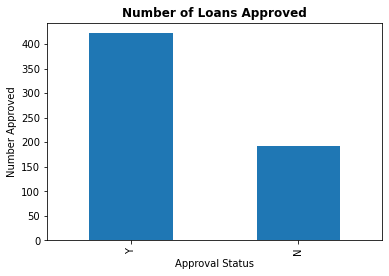

In [9]:
train['Loan_Status'].value_counts().plot.bar() 
plt.title("Number of Loans Approved",fontweight='bold')
plt.xlabel('Approval Status' )
plt.ylabel('Number Approved')

Using and plotting a correlation matrix using seaborn we can view the relationship between some features to get a better understanding of our data

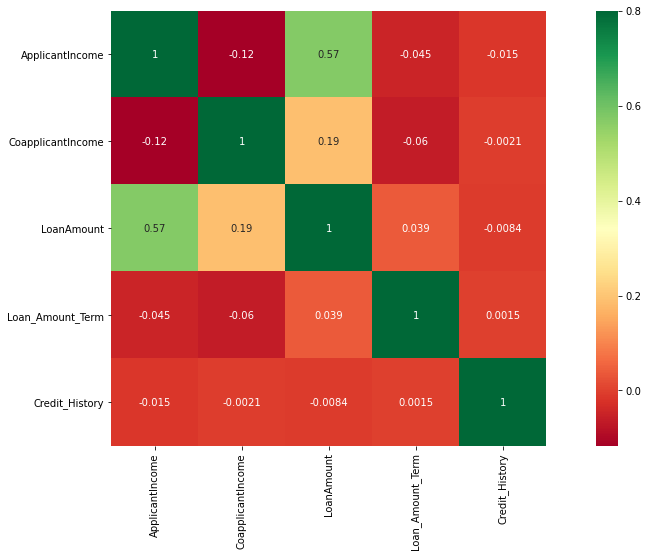

In [10]:
matrix = train.corr() # seeing the correlation between cells further explanation is needed
f, ax = plt.subplots(figsize=(18, 8)) 
sns.heatmap(matrix, vmax=.8, square=True, cmap="RdYlGn",annot = True);

We notice a decent correlation for the loan amount and the applicant income. Most likely the higher a applicant makes the bigger the loan they are requesting. 

## Data Cleaning

Let's First check for missing values 

In [11]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [12]:
test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

We notice that there are some null values and for the categorial variables we choose to replace them with the mode or the most common value. We are going to create a function to turn replace the null values with the mode. 

In [13]:
def remove_null(column,df): # rename fill null 
    df[column].fillna(df[column].mode()[0], inplace= True) 

Looping through the categorical columns using the function we built and replacing the null values with the mode. 

In [14]:
categorical_columns = ['Gender','Married','Dependents','Self_Employed','Credit_History']

for column in categorical_columns:
    remove_null(column, train)

In [15]:
for column in categorical_columns:
    remove_null(column, test)

In [16]:
test.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           5
Loan_Amount_Term     6
Credit_History       0
Property_Area        0
dtype: int64

We got rid of all the categorical variables now time to deal with the numerical variables.

In [17]:
train['Loan_Amount_Term'].value_counts() # lets look at the numerical variables in loan amount term

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [18]:
train['LoanAmount'].value_counts() # lets look at the numerical variables in loan amount

120.0    20
110.0    17
100.0    15
187.0    12
160.0    12
         ..
570.0     1
300.0     1
376.0     1
117.0     1
311.0     1
Name: LoanAmount, Length: 203, dtype: int64

Normally for numerical variables we would be inclined to take the mean, however, we can see that the loan amount terms are specific amounts and taking the average would not make much sense. We also know that there are outliers for the loan amount therefore we can use the same function for that replaces the values with the mode for the numerical variables. 

In [19]:
numerical_columns = [ 'LoanAmount', 'Loan_Amount_Term']
for column in numerical_columns:
    remove_null(column, train)

In [20]:
for column in numerical_columns:
    remove_null(column, test)

In [21]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Now we are now going to transform the categoricals variables into numbers and encode them in order for our algorithm to properly interpret them. 

In [22]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,120.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [23]:
train['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

We are going to use the label encoder function to transform the categorical variables that are binary. 

In [24]:
le= preprocessing.LabelEncoder() # explain why label encoding and not ohe 
train['Loan_Status'] = le.fit_transform(train['Loan_Status']) 

Looping through the categories and encoding them. 

In [25]:
#def encode_features(df): # said I needed a random state
features = ['Gender','Married','Education','Self_Employed',] #add loan status here 
    
for feature in features: # whats the difference between OHE and Label encoder 
    le.fit(train[feature])
    train[feature]= le.transform(train[feature])
    test[feature]= le.transform(test[feature])


train.head()    

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,120.0,360.0,1.0,Urban,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,Urban,1


In [26]:
train['Property_Area'].value_counts() #this is not a binary collumn

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

We are going to use the get dummies function to encode the singular collumn that is not binary. Normally we would use OHE but its a singular column thats a series therefore the get dummies function works better.

In [27]:
train_encoded = pd.get_dummies(train,prefix=['Property_Area'], columns = ['Property_Area'], drop_first=True)

In [28]:
train_encoded

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,1,0,0,0,0,5849,0.0,120.0,360.0,1.0,1,0,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,1,0,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,1,0,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,0,0,0,0,2900,0.0,71.0,360.0,1.0,1,0,0
610,LP002979,1,1,3+,0,0,4106,0.0,40.0,180.0,1.0,1,0,0
611,LP002983,1,1,1,0,0,8072,240.0,253.0,360.0,1.0,1,0,1
612,LP002984,1,1,2,0,0,7583,0.0,187.0,360.0,1.0,1,0,1


Lets check all the data types 

We are going to try and combine applicant income to coaplicant income and also the monthly installment

In [30]:
train_encoded["Total_Income"]= train['ApplicantIncome'] + train['CoapplicantIncome']
train_encoded['Monthly_Installments']= train['LoanAmount']/train['Loan_Amount_Term']



In [31]:
train_encoded.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Semiurban,Property_Area_Urban,Total_Income,Monthly_Installments
0,LP001002,1,0,0,0,0,5849,0.0,120.0,360.0,1.0,1,0,1,5849.0,0.333333
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0,0,6091.0,0.355556
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,1,0,1,3000.0,0.183333
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,1,0,1,4941.0,0.333333
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,1,0,1,6000.0,0.391667


In [32]:
train_encoded.dtypes

Loan_ID                     object
Gender                       int32
Married                      int32
Dependents                  object
Education                    int32
Self_Employed                int32
ApplicantIncome              int64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
Loan_Status                  int32
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
Total_Income               float64
Monthly_Installments       float64
dtype: object

We notice that we have to variables of the type object we will drop the Loan_ID before loading it into the X value as for the dependents we need to either drop it or change it from strings into numbers.

In [33]:
train_encoded['Dependents'].value_counts()

0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64

We notice that the categories for the dependents columns are just numbers that have been set as catogories we just need to replace them with their numerical counterparts. We will proceed to loop through them and replace them. 

In [34]:
data_frames= [train_encoded, test]
for df in data_frames:
    df['Dependents'].replace({'0': 0, '1': 1, '2': 2, '3+':3}, inplace = True)

Checking to see if we have elimated all the categorical variables

In [35]:
train_encoded.dtypes

Loan_ID                     object
Gender                       int32
Married                      int32
Dependents                   int64
Education                    int32
Self_Employed                int32
ApplicantIncome              int64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
Loan_Status                  int32
Property_Area_Semiurban      uint8
Property_Area_Urban          uint8
Total_Income               float64
Monthly_Installments       float64
dtype: object

Now we can start modeling

## Modeling 

In [36]:
X= train_encoded.drop(['Loan_ID', 'Loan_Status'], axis= 1 ) # droping the Loan_ID column before loading it into the X varible like previously stated
y= train_encoded['Loan_Status'] 

Splitting it into train test split and assigning it random_state 42 in order to get consistant results. 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .25, random_state=42)

We then proceed to scale the model after splitting it in order to prevent data from leaking into the test set. 

In [38]:
scaler= StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

We will first start off with a dummy classifier with the most frequent class being the strategy to evaluate the model.

In [39]:
dclf = DummyClassifier(strategy = "most_frequent", random_state = 42) 
dclf.fit(X_train_scaled, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [40]:
dclf_pred=dclf.predict(X_test_scaled)
accuracy_score(y_test, dclf_pred)

0.6493506493506493

We optain a accurracy of about 65% but we know that is not the best metric to use as blindly predicting will lead us to at least a 65% accuracy we also need to make sure that the model doesn't favor the majority class therefore we will be using precision as our main metric while viewing and trying to improve other metrics as well such as recall. 

In [41]:
precision_score(y_test, dclf_pred) # we get the same level of precision

0.6493506493506493

In [42]:
print(classification_report(y_test, dclf_pred)) # printing out the classification report to get a better understanding of every metrics performance

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.65      1.00      0.79       100

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154



C:\Users\rompalme\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now we can start using te different classifying algorithms lets start with the decision tree model.


In [43]:
dtcf= DecisionTreeClassifier(random_state=42) # do we have to put a random state here?
dtcf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [44]:
dtcf_pred= dtcf.predict(X_test_scaled)

In [45]:
precision_score(y_test, dtcf_pred) # so here we get our very first performance on the model

0.76

We can see that we got an improvement of about 12% in the precision score. 

Lets see if we can improve the model with grid search

In [46]:
grid= ({'max_depth': [4, 5, 6, 7],
        'min_samples_split': [6,7,8,9,10]}) #how did we pick out he numbers for the Decision Tree


grid_dt= GridSearchCV(dtcf, param_grid= grid, scoring= 'accuracy', cv=3, verbose=1) # find out the role of cv and verbose

grid_dt.fit(X_train_scaled,y_train)

print(grid_dt.best_score_)

best_dt_estimator= grid_dt.best_estimator_
print(best_dt_estimator)
best_dt_estimator_pred= best_dt_estimator.predict(X_test_scaled)
precision_score(y_test, best_dt_estimator_pred) #why is the score and the accuracy different

Fitting 3 folds for each of 20 candidates, totalling 60 fits
0.7935376170670289
DecisionTreeClassifier(max_depth=4, min_samples_split=6, random_state=42)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished


0.76

In [47]:
print(classification_report(y_test, best_dt_estimator_pred)) # we are printing out the classification report for the best Decision Tree Model

              precision    recall  f1-score   support

           0       0.83      0.44      0.58        54
           1       0.76      0.95      0.84       100

    accuracy                           0.77       154
   macro avg       0.79      0.70      0.71       154
weighted avg       0.78      0.77      0.75       154



We don't see an improvement in precision of the grid searcch that was done but we do see an improvement in other metrics such as the f1 score therfore we can say the gridsearch was successful in giving us a better model

Creating a confusion matrix to better visualize the data

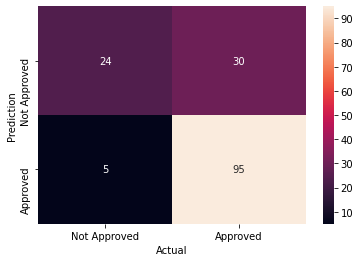

In [48]:
cm= confusion_matrix(y_test, best_dt_estimator_pred)
sns.heatmap(cm, 
            annot=True,
            fmt='g',
            xticklabels=['Not Approved','Approved'],
            yticklabels=['Not Approved','Approved'])
           
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

Now lets try the random forest classifier model

In [49]:
rdf= RandomForestClassifier()

In [50]:
rdf.fit(X_train_scaled, y_train,) # revisit the sample weight

RandomForestClassifier()

In [51]:
rdf_pred= rdf.predict(X_test_scaled)
precision_score(y_test, rdf_pred) 

0.768

We got a better original score as expected of the random forest model lets see if we can tune some of its parameters to be even more accurate


In [52]:
grid_rdf_params= ({'n_estimators': [100,150,200,500],
           'max_depth': [4,5,6,7],
           'min_samples_leaf': [6,10,14], # why these numbers
            'min_samples_split': [4,5,6,7]})

grid_rdf= GridSearchCV(rdf, param_grid= grid_rdf_params, scoring='precision', cv= 3, verbose=1) # changed scoring to precison

grid_rdf.fit(X_train_scaled, y_train)




Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 576 out of 576 | elapsed:  2.3min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'min_samples_leaf': [6, 10, 14],
                         'min_samples_split': [4, 5, 6, 7],
                         'n_estimators': [100, 150, 200, 500]},
             scoring='precision', verbose=1)

In [54]:
best_rdf_estimator= grid_rdf.best_estimator_

best_rdf_estimator_pred= best_rdf_estimator.predict(X_test)
precision_score(y_test, best_rdf_estimator_pred) #why are we getting a lower score after grid search?

0.6493506493506493

We are getting a lower score with the grid scearch therefore lets stick to the original model 

In [55]:
print(classification_report(y_test, rdf_pred)) # we can see that all the metrics went up which shows an improvement in our overall model

              precision    recall  f1-score   support

           0       0.86      0.46      0.60        54
           1       0.77      0.96      0.85       100

    accuracy                           0.79       154
   macro avg       0.82      0.71      0.73       154
weighted avg       0.80      0.79      0.77       154



We do not see an improvement in precision but we do see one in recall. 

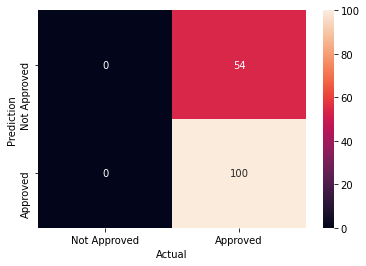

In [56]:
cm_rdf= confusion_matrix(y_test, best_rdf_estimator_pred)
sns.heatmap(cm_rdf, 
            annot=True,
            fmt='g',
           xticklabels=['Not Approved','Approved'],
            yticklabels=['Not Approved','Approved'])

plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

Doesnt seem like it helped why is that

Now lets try the XGBoost Classifier. 

have a confusion matrix decide which metric is most important ( classification report)

In [57]:
import xgboost as xgb
from xgboost import XGBClassifier

In [58]:
xgb= XGBClassifier(n_estimator=500, learning_rate=.5, max_depth=3) # why did we choose these parameters 
evals= [(X_test_scaled, y_test)] # apperanl increasing the learnign rate makes it a better model 
xgb.fit(X_train_scaled, y_train, # why cant I do X_train_scaled
    eval_set=evals,
    eval_metric="error", #what does error do 
    verbose= True)


[13:00:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.24026
[1]	validation_0-error:0.24026
[2]	validation_0-error:0.23377
[3]	validation_0-error:0.23377
[4]	validation_0-error:0.23377
[5]	validation_0-error:0.23377
[6]	validation_0-error:0.24026
[7]	validation_0-error:0.22078
[8]	validation_0-error:0.22078
[9]	validation_0-error:0.22727
[10]	validation_0-error:0.22727
[11]	validation_0-error:0.21429
[12]	validation_0-error:0.22078
[13]	validation_0-error:0.22078
[14]	validation_0-error:0.22727
[15]	validation_0-error:0.22727
[16]	validation_0-error:0.22727
[17]	validation_0-error:0.20779
[18]	validation_0-error:0.20779
[19]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimator=500, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [59]:
xgb_pred= xgb.predict(X_test_scaled)
precision_score(y_test, xgb_pred)

0.775

In [60]:
xgb_= XGBClassifier()

In [61]:
grid_xgb_params= ({'n_estimators': [100,200,300,400,500],
           'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], # why cant it be 1
                  'max_depth': [3]})

grid_xgb= GridSearchCV(xgb_, param_grid= grid_xgb_params, scoring='precision', cv= 3, verbose=1) # changed scoring to precison

grid_xgb.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    6.3s finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [64]:
grid_xgb.best_estimator_ # this model is overfitting and we are working on this issue

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
best_xgb_estimator= grid_xgb.best_estimator_

best_xgb_estimator_pred= best_xgb_estimator.predict(X_test_scaled)
precision_score(y_test, best_xgb_estimator_pred)

0.7768595041322314

In [66]:
print(classification_report(y_test, best_xgb_estimator_pred))

              precision    recall  f1-score   support

           0       0.82      0.50      0.62        54
           1       0.78      0.94      0.85       100

    accuracy                           0.79       154
   macro avg       0.80      0.72      0.74       154
weighted avg       0.79      0.79      0.77       154



We noticed that the XGBoost model is the best model slighly improving it with the grid search. It has the highest level of precision and the highest F1 score which is a combination of precision and recall

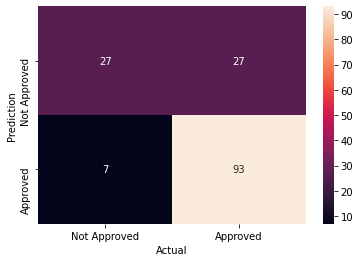

In [67]:
cm_xgb= confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, 
            annot=True,
            fmt='g',
            xticklabels=['Not Approved','Approved'],
            yticklabels=['Not Approved','Approved'])
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

Now lets see if our model is overfitting or underfitting

In [68]:
best_xgb_train_pred=  best_xgb_estimator.predict(X_train_scaled)
precision_score(y_train, best_xgb_train_pred) 

0.972809667673716

We notice that there is a lot of overfitting in our model as our training precision is much higher than our testing precision. This is something that would need to be addressed in improving our final model. 

Now lets look at the features that the model believes were important when making a decision

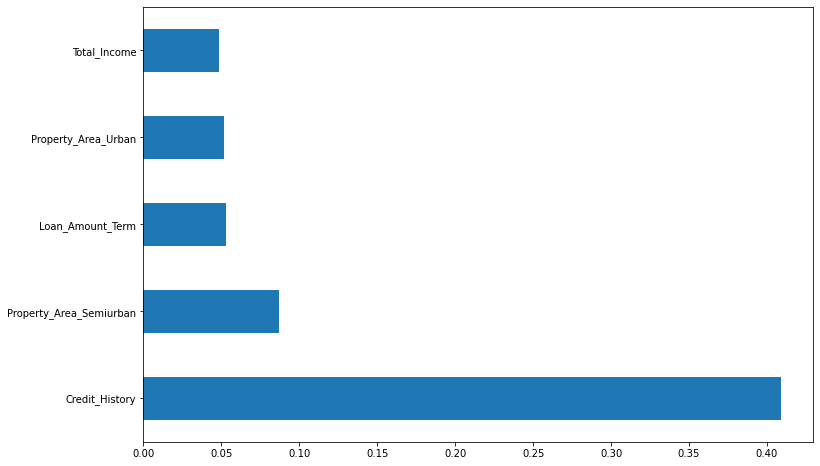

In [69]:
importances=pd.Series(xgb.feature_importances_, index=X.columns) 
importances.nlargest(5).plot(kind='barh', figsize=(12,8));  #function that display the top 5 features 

Once we found the most important features we can take a deeper look at them through visualizations that will allow us to make recommendations to the company.

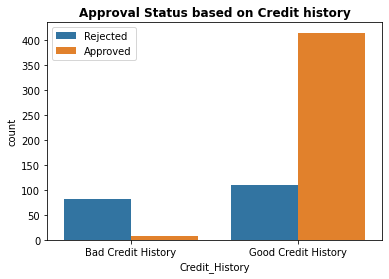

In [70]:
sns.countplot(x='Credit_History', hue= 'Loan_Status', data=train)
plt.title("Approval Status based on Credit history",fontweight='bold')
x1 = [0,1,]
squad = ['Bad Credit History','Good Credit History']

plt.xticks(x1, squad)
plt.legend(['Rejected', 'Approved'])

#how can I have that as a percentage

We can see that those with a good credit history where approved for the loan while those with a bad credit history where more ofthen rejected than approved. 

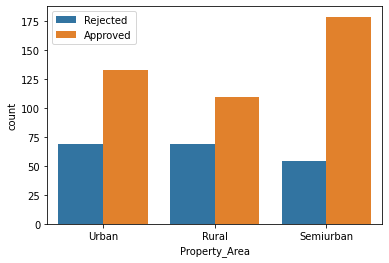

In [71]:
sns.countplot(x='Property_Area', hue= 'Loan_Status', data=train)
plt.legend(['Rejected', 'Approved'])

We notice that Semi Urban areas have the most likely hood of success while those in rural areas are most likely to be rejected

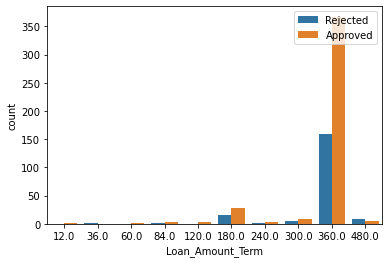

In [72]:
sns.countplot(x='Loan_Amount_Term', hue = 'Loan_Status', data=train)
plt.legend(['Rejected', 'Approved'])

Lastly we notice that the standard loan amount term which is 360 months has the highest likely hood of being approved. 

These are all recommendations that we can give the company in regards to the loan approval process